# Install necessary packages

In [ ]:
!pip install ultralytics supervision --quiet

In [ ]:
from pathlib import Path
import os

In [ ]:
HOME = os.getcwd()

# The name for the project
PROJECT_NAME = f"Tracker"

# The path for the project folder
PROJECT_DIR = Path(f"./{PROJECT_NAME}")

# Create the project directory if it does not already exist
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

%cd {PROJECT_DIR}

# Default GOOGLE DRIVE
GDRIVE_VID_PATH = f"/content/drive/MyDrive/detect_human/Samples"

/content/Tracker


In [ ]:
!gdown 1gglIwqxaH2iTvy6lZlXuAcMpd_U0GCUb

Downloading...
From: https://drive.google.com/uc?id=1gglIwqxaH2iTvy6lZlXuAcMpd_U0GCUb
To: /content/Tracker/crowdhuman_yolov5m.pt
100% 169M/169M [00:00<00:00, 172MB/s]


# Build Model

In [ ]:
WEIGHT = "crowdhuman_yolov5m.pt"

In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import models

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=WEIGHT, device=0)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-23 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 308 layers, 21041679 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline

def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
  video = cv2.VideoCapture(video_file)

  while video.isOpened():
    success, frame = video.read()

    if not success:
      break

    yield frame

  video.release()

def plot_image(image: np.ndarray, size: int = 12) -> None:
  plt.figure(figsize=(size, size))
  plt.imshow(image[..., ::-1])
  plt.show()

In [ ]:
SOURCE_VIDEO_PATH = f"{GDRIVE_VID_PATH}/_01_Event20151003122418026_032_K1S1.mp4"

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

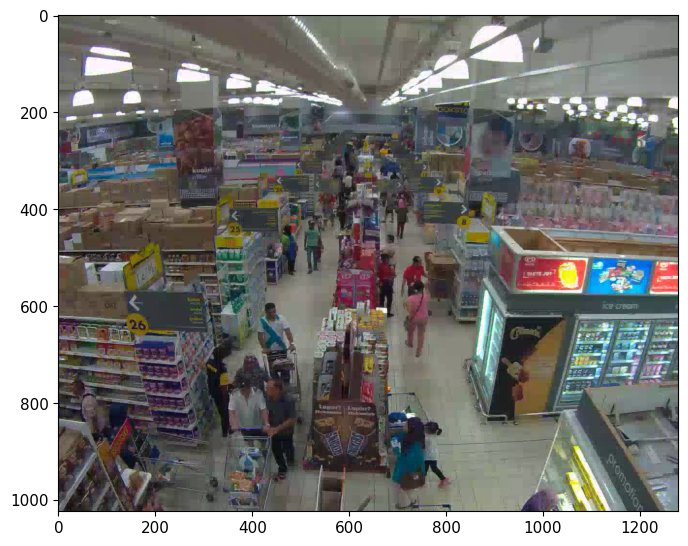

In [ ]:
frame = next(frame_iterator)
plot_image(frame, 8)

In [ ]:
results = model(frame, size=1280)

In [ ]:
results.pandas()
results.pred[0]
model.names

{0: 'person', 1: 'head'}

In [ ]:
%cd {HOME}

/content


In [ ]:
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

fatal: destination path 'ByteTrack' already exists and is not an empty directory.
  Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)
  Using cached motmetrics-1.4.0-py3-none-any.whl (161 kB)
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached onnx-1.8.1.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.16.2, 1.16.3)
ERROR: No matching distribution found for onnxruntime==1.8.0
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        *********************************************

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

!pip install onemetric --quiet

In [ ]:
!pip install loguru lap --quiet

# PUT EVERYTHING TOGETHER

In [ ]:
SOURCE_VIDEO_FILE = f"{GDRIVE_VID_PATH}/++_01_Cam01_20171223132726_300__K1S2.mp4"
TARGET_VIDEO_FILE = f"{HOME}/++_01_Cam01_20171223132726_300__K1S2_RESULT.mp4"

In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.3
  track_buffer: int = 600
  match_thresh: float = 0.6
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = True

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

# geometry utilities


@dataclass(frozen=True)
class Point:
  x: float
  y: float

  @property
  def int_xy_tuple(self) -> Tuple[int, int]:
    return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
  x: float
  y: float
  width: float
  height: float

  @property
  def min_x(self) -> float:
    return self.x

  @property
  def min_y(self) -> float:
    return self.y

  @property
  def max_x(self) -> float:
    return self.x + self.width

  @property
  def max_y(self) -> float:
    return self.y + self.height

  @property
  def top_left(self) -> Point:
    return Point(x=self.x, y=self.y)

  @property
  def bottom_right(self) -> Point:
    return Point(x=self.x + self.width, y=self.y + self.height)

  @property
  def bottom_center(self) -> Point:
    return Point(x=self.x + self.width / 2, y=self.y + self.height)

  @property
  def top_center(self) -> Point:
    return Point(x=self.x + self.width / 2, y=self.y)

  @property
  def center(self) -> Point:
    return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

  def pad(self, padding: float) -> Rect:
    return Rect(
        x=self.x - padding,
        y=self.y - padding,
        width=self.width + 2*padding,
        height=self.height + 2*padding
    )

  def contains_point(self, point: Point) -> bool:
    return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
  rect: Rect
  class_id: int
  class_name: str
  confidence: float
  tracker_id: Optional[int] = None

  @classmethod
  def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
    result = []
    for x_min, y_min, x_max, y_max, confidence, class_id in pred:
      class_id=int(class_id)
      result.append(Detection(
        rect=Rect(
          x=float(x_min),
          y=float(y_min),
          width=float(x_max - x_min),
          height=float(y_max - y_min)
        ),
        class_id=class_id,
        class_name=names[class_id],
        confidence=float(confidence)
      ))
    return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
  return [
    detection
    for detection
    in detections
    if detection.class_name == class_name
  ]


# draw utilities


@dataclass(frozen=True)
class Color:
  r: int
  g: int
  b: int

  @property
  def bgr_tuple(self) -> Tuple[int, int, int]:
    return self.b, self.g, self.r

  @classmethod
  def from_hex_string(cls, hex_string: str) -> Color:
    r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
    return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
  cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
  return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
  cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
  return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
  cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
  return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
  cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
  return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
  cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
  return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
  cv2.ellipse(
    image,
    center=rect.bottom_center.int_xy_tuple,
    axes=(int(rect.width), int(0.35 * rect.width)),
    angle=0.0,
    startAngle=-45,
    endAngle=235,
    color=color.bgr_tuple,
    thickness=thickness,
    lineType=cv2.LINE_4
  )
  return image


# base annotator


@dataclass
class BaseAnnotator:
  colors: List[Color]
  thickness: int

  def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
    annotated_image = image.copy()
    for detection in detections:
      annotated_image = draw_ellipse(
        image=image,
        rect=detection.rect,
        color=self.colors[detection.class_id],
        thickness=self.thickness
      )
    return annotated_image

In [ ]:
# green
HEAD_HEX = "#00D4BB"
HEAD_COLOR = Color.from_hex_string(HEAD_HEX)

# yellow
PERSON_HEX = "#FFFF00"
PERSON_COLOR = Color.from_hex_string(PERSON_HEX)

COLORS = [
    HEAD_COLOR,
    PERSON_COLOR
]
THICKNESS = 4

In [ ]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_FILE))

In [ ]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)


In [ ]:
frame.shape

(720, 1280, 3)

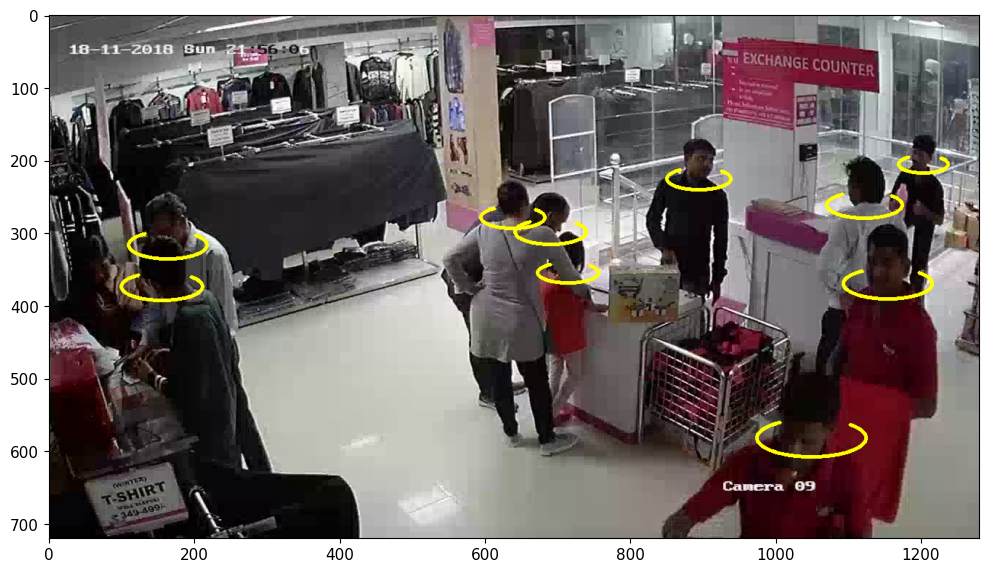

In [ ]:
# run detector
results = model(frame, size=640)
detections = Detection.from_results(
  pred=results.pred[0].cpu().numpy(), names=model.names)

person_detetions = filter_detections_by_class(detections=detections, class_name="head")

# annotate video frame
annotated_image = annotator.annotate(
    image=frame,
    detections=person_detetions)

# plot video frame
plot_image(annotated_image)

In [ ]:
from typing import List

import numpy as np

In [ ]:
# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


In [ ]:
# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [ ]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                thickness=self.text_thickness)
            width, height = size

            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10

            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image,
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5),
                color=self.background_color)

            # draw text
            annotated_image = draw_text(
                image=annotated_image,
                anchor=Point(x=x, y=y + height),
                text=str(detection.tracker_id),
                color=self.text_color,
                thickness=self.text_thickness)
        return annotated_image

In [ ]:
from tqdm.notebook import tqdm

vid_cap = cv2.VideoCapture(SOURCE_VIDEO_FILE)

FPS = vid_cap.get(cv2.CAP_PROP_FPS)
WIDTH = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
HEIGHT = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# initiate video writer
video_config = VideoConfig(fps=FPS, width=WIDTH, height=HEIGHT)
video_writer = get_video_writer(target_video_path=TARGET_VIDEO_FILE, video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_FILE))

# initiate annotators
text_annotator = TextAnnotator(background_color=COLORS[0], text_color=Color(0, 0, 0), text_thickness=2)

# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator):

    # run detector
    results = model(frame, size=640)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)

    # postprocess results
    head_detections = filter_detections_by_class(detections=detections, class_name="head")
    person_detections = filter_detections_by_class(detections=detections, class_name="person")
    tracked_detections = head_detections + person_detections

    # track human
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    human_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = text_annotator.annotate(
        image=annotated_image,
        detections=human_detections)
    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

0it [00:00, ?it/s]

In [ ]:
from google.colab import files
files.download(TARGET_VIDEO_FILE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>